## **Dataset Selection**

In [ ]:
! pip install -q kaggle
#from google.colab import files
#files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#! kaggle datasets download -d mirichoi0218/insurance

#! unzip insurance.zip -d health-insurance

In [ ]:
! kaggle datasets download -d mirichoi0218/insurance

! unzip insurance.zip -d health-insurance

  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 29.9MB/s]
Archive:  insurance.zip
  inflating: health-insurance/insurance.csv  


## **Importing Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats  
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
import numpy as np
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Reading and summarizing the data**

In [ ]:
health_ins_df = pd.read_csv("health-insurance/insurance.csv")

In [ ]:
health_ins_df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
health_ins_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [ ]:
health_ins_df.shape
#There are 1338 rows and 7 columns

(1338, 7)

In [ ]:
health_ins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
health_ins_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## **Data Cleaning and Exploratory Data Analysis**

In [ ]:
#Finding null values
health_ins_df.isnull().sum()

#There are no null values in the dataset

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### **Visualizing numerical variables**

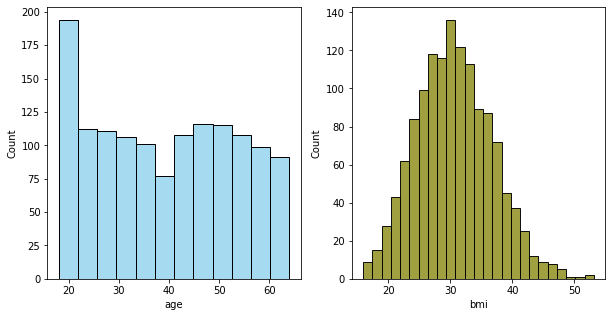

In [ ]:
#Visualizing age column with a histogram
fig,axes=plt.subplots(1,2,figsize=(10,5))
sns.histplot( health_ins_df['age'] , color="skyblue",ax=axes[0])
sns.histplot( health_ins_df['bmi'] , color="olive",ax=axes[1])
plt.show()

*   We will convert age into age bracket
*   BMI is close to normal distribution

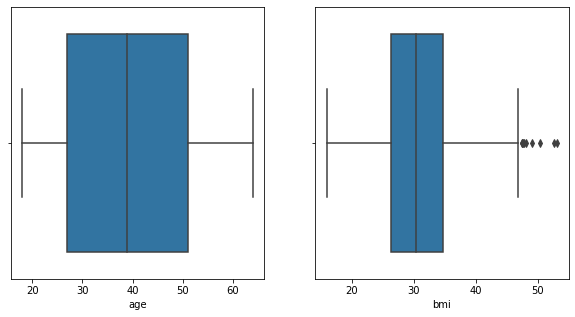

In [ ]:
#Visualizing age column with a boxplot
fig,axes=plt.subplots(1,2,figsize=(10,5))

sns.boxplot(x = 'age', data = health_ins_df, ax=axes[0])
sns.boxplot(x = 'bmi', data = health_ins_df, ax=axes[1])

plt.show()

In [ ]:
#Finding the outlier values in the bmi column
outlier_list = boxplot_stats(health_ins_df.bmi).pop(0)['fliers'].tolist()
print(outlier_list)

#Finding the number of rows containing outliers
outlier_bmi_rows = health_ins_df[health_ins_df.bmi.isin(outlier_list)].shape[0]
print("Number of rows contaning outliers in bmi : ", outlier_bmi_rows)

#Percentage of rows which are outliers
percent_bmi_outlier = (outlier_bmi_rows/health_ins_df.shape[0])*100
print("Percentage of outliers in bmi columns : ", percent_bmi_outlier)

[49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.58, 47.74, 53.13]
Number of rows contaning outliers in bmi :  9
Percentage of outliers in bmi columns :  0.672645739910314


The outlier % is neglible (0.67%). Hence these rows can be dropped

### **Data Transformation of Numerical Variables**

In [ ]:
#Converting age into age brackets
print("Minimum value for age : ", health_ins_df['age'].min(),"\nMaximum value for age : ", health_ins_df['age'].max())

#Age between 18 to 40 years will fall under young
#Age between 41 to 58 years will fall under mid-age
#Age above 58 years will fall under old age

health_ins_df.loc[(health_ins_df['age'] >=18) & (health_ins_df['age'] <= 40), 'age_group'] = 'young'
health_ins_df.loc[(health_ins_df['age'] >= 41) & (health_ins_df['age'] <= 58), 'age_group'] = 'mid-age'
health_ins_df.loc[health_ins_df['age'] > 58, 'age_group'] = 'old'


Minimum value for age :  18 
Maximum value for age :  64


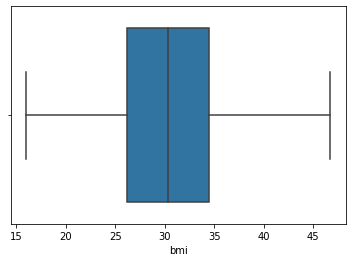

In [ ]:
#Removing outier from bmi column
health_ins_df_clean = health_ins_df[~health_ins_df.bmi.isin(outlier_list)]
sns.boxplot(x = 'bmi', data = health_ins_df_clean)

### **Visualizing categorical variables**

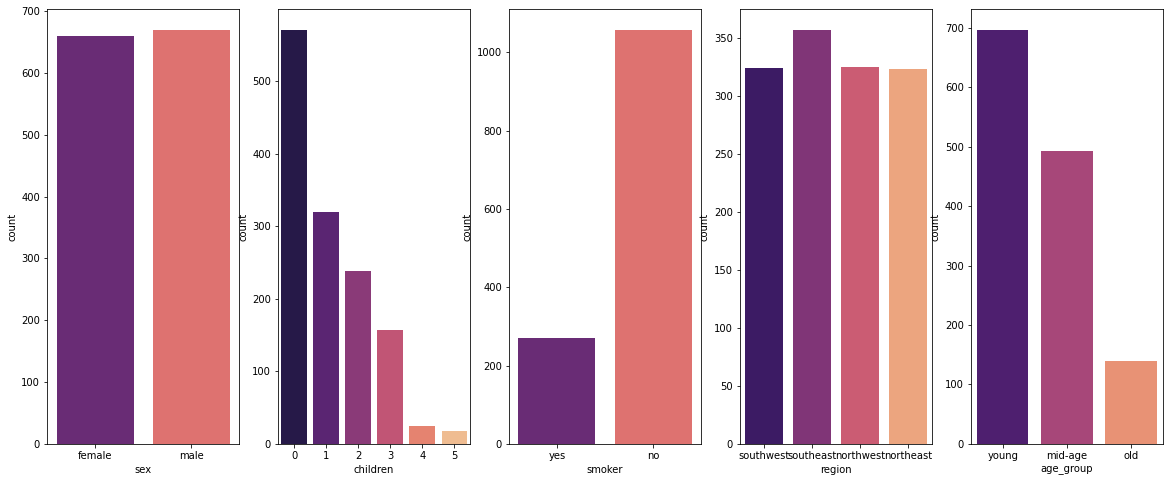

In [ ]:
fig,axes=plt.subplots(1,5,figsize=(20,8))
sns.countplot(x = 'sex', data = health_ins_df_clean, palette = 'magma',ax=axes[0])
sns.countplot(x = 'children', data = health_ins_df_clean, palette = 'magma',ax=axes[1])
sns.countplot(x = 'smoker', data = health_ins_df_clean, palette = 'magma',ax=axes[2])
sns.countplot(x = 'region', data = health_ins_df_clean, palette = 'magma',ax=axes[3])
sns.countplot(x = 'age_group', data = health_ins_df_clean, palette = 'magma',ax=axes[4])

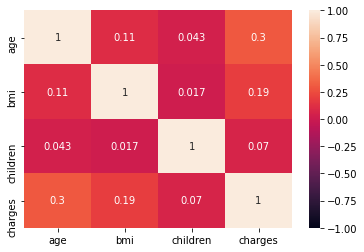

In [ ]:
heatmap = sns.heatmap(health_ins_df_clean.corr(), vmin=-1, vmax=1, annot=True)

Age and BMI are comparatively more closely related to charges

### **Multivariate Analysis**

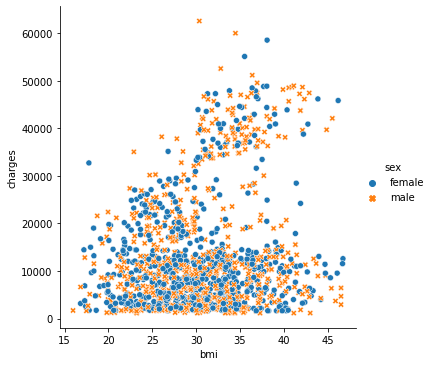

In [ ]:
sns.relplot(x="bmi", y="charges",hue="sex", style = "sex", data=health_ins_df_clean);

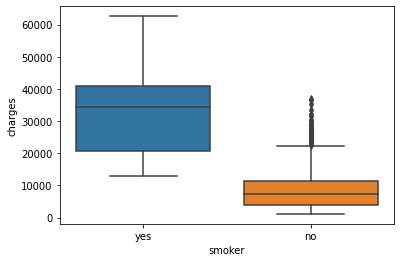

In [ ]:
sns.boxplot(x="smoker", y="charges", data=health_ins_df_clean)

## **Model Building**

### **Data Pre-processing**

In [ ]:
#Number of categories in catagorical variables
categorical_var = ['sex','children','smoker','region','age_group']
for cat_value in categorical_var:
  print(cat_value," - ",health_ins_df_clean[cat_value].unique())

sex  -  ['female' 'male']
children  -  [0 1 3 2 5 4]
smoker  -  ['yes' 'no']
region  -  ['southwest' 'southeast' 'northwest' 'northeast']
age_group  -  ['young' 'mid-age' 'old']


In [ ]:
#Converting categorical values into dummies using one-hot encoding technique
health_ins_df_processed = pd.get_dummies(health_ins_df_clean, columns=['sex','children','smoker','region','age_group'], prefix=['sex','children','smoker','region','age_group'])
health_ins_df_processed.drop(['age'],axis = 1,inplace=True)

In [ ]:
health_ins_df_processed.head(5)

,bmi,charges,sex_female,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
0,27.900,16884.92400,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,33.770,1725.55230,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,33.000,4449.46200,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,22.705,21984.47061,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,28.880,3866.85520,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1


### **Building base model**

In [ ]:
#Building linear regression model
X = health_ins_df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:17:24   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4565.8126    360.93

*   Adjusted R-square is 75.1% means our model is able to explain 75.1% variation in the data
*   We see that for variables - children_1,children_2,children_3,children_5,region_northwest,region_southeast,region_southwest,age_group_mid-age the p-value > alpha which means that these variables are insignificant in predicting our target variable - charges
*   We will drop these insignificant variables in next iteration






In [ ]:
health_ins_df_processed.columns

Index(['bmi', 'charges', 'sex_female', 'sex_male', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4', 'children_5', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'age_group_mid-age',
       'age_group_old', 'age_group_young'],
      dtype='object')

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi', 'sex_female', 'sex_male', 'children_0', 'children_1','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female       inf
2            sex_male       inf
3          children_0       inf
4          children_1       inf
5          children_2       inf
6          children_3       inf
7          children_4       inf
8          children_5       inf
9           smoker_no       inf
10         smoker_yes       inf
11   region_northeast       inf
12   region_northwest       inf
13   region_southeast       inf
14   region_southwest       inf
15  age_group_mid-age       inf
16      age_group_old       inf
17    age_group_young       inf


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
#Dropping children_1
X = health_ins_df_processed[['bmi','sex_female', 'sex_male', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:17:49   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4566.9072    382.07

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi', 'sex_female', 'sex_male', 'children_0', 'children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female       inf
2            sex_male       inf
3          children_0  1.623418
4          children_2  1.436293
5          children_3  1.324000
6          children_4  1.060919
7          children_5  1.049968
8           smoker_no       inf
9          smoker_yes       inf
10   region_northeast       inf
11   region_northwest       inf
12   region_southeast       inf
13   region_southwest       inf
14  age_group_mid-age       inf
15      age_group_old       inf
16    age_group_young       inf


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
health_ins_df_vif.corr(method ='pearson')

,bmi,sex_female,sex_male,children_0,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
bmi,1.000000,-0.039958,0.039958,-0.012986,0.023607,0.009091,0.019978,-0.018461,0.002871,-0.002871,-0.136193,-0.128598,0.255863,0.000651,0.061722,0.070413,-0.102850
sex_female,-0.039958,1.000000,-1.000000,0.014784,-0.003984,-0.003964,-0.015470,-0.012050,0.079854,-0.079854,-0.000573,0.009961,-0.010263,0.001195,0.011029,0.010205,-0.016922
sex_male,0.039958,-1.000000,1.000000,-0.014784,0.003984,0.003964,0.015470,0.012050,-0.079854,0.079854,0.000573,-0.009961,0.010263,-0.001195,-0.011029,-0.010205,0.016922
children_0,-0.012986,0.014784,-0.014784,1.000000,-0.405377,-0.317665,-0.120175,-0.101699,0.009183,-0.009183,0.029145,-0.027001,0.002113,-0.004267,-0.122139,0.150396,0.025982
children_2,0.023607,-0.003984,0.003984,-0.405377,1.000000,-0.170947,-0.064671,-0.054728,-0.026637,0.026637,-0.035887,0.035606,0.009155,-0.009244,0.063833,-0.082676,-0.011082
children_3,0.009091,-0.003964,0.003964,-0.317665,-0.170947,1.000000,-0.050678,-0.042887,-0.040420,0.040420,0.004580,0.041256,-0.037731,-0.006925,0.027797,0.004414,-0.029592
children_4,0.019978,-0.015470,0.015470,-0.120175,-0.064671,-0.050678,1.000000,-0.016224,0.028837,-0.028837,0.011931,-0.001464,-0.021437,0.011676,-0.003140,-0.029224,0.020945
children_5,-0.018461,-0.012050,0.012050,-0.101699,-0.054728,-0.042887,-0.016224,1.000000,0.043146,-0.043146,-0.020864,-0.051521,0.017107,0.054758,-0.009126,-0.040047,0.033367
smoker_no,0.002871,0.079854,-0.079854,0.009183,-0.026637,-0.040420,0.028837,0.043146,1.000000,-1.000000,-0.004947,0.035940,-0.068270,0.039440,0.029108,-0.016209,-0.018222
smoker_yes,-0.002871,-0.079854,0.079854,-0.009183,0.026637,0.040420,-0.028837,-0.043146,-1.000000,1.000000,0.004947,-0.035940,0.068270,-0.039440,-0.029108,0.016209,0.018222


In [ ]:
#Dropping sex_male
X = health_ins_df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:35:09   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5647.7031    482.76

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.096394
1          sex_female  1.009197
2          children_0  1.623418
3          children_2  1.436293
4          children_3  1.324000
5          children_4  1.060919
6          children_5  1.049968
7           smoker_no       inf
8          smoker_yes       inf
9    region_northeast       inf
10   region_northwest       inf
11   region_southeast       inf
12   region_southwest       inf
13  age_group_mid-age       inf
14      age_group_old       inf
15    age_group_young       inf


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
#Dropping smoker_no
X = health_ins_df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:35:20   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                19.0403    636.55

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female  1.009197
2          children_0  1.623418
3          children_2  1.436293
4          children_3  1.324000
5          children_4  1.060919
6          children_5  1.049968
7          smoker_yes  1.019222
8    region_northeast       inf
9    region_northwest       inf
10   region_southeast       inf
11   region_southwest       inf
12  age_group_mid-age       inf
13      age_group_old       inf
14    age_group_young       inf


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
health_ins_df_vif.corr(method ='pearson')

,bmi,sex_female,children_0,children_2,children_3,children_4,children_5,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
bmi,1.000000,-0.039958,-0.012986,0.023607,0.009091,0.019978,-0.018461,-0.002871,-0.136193,-0.128598,0.255863,0.000651,0.061722,0.070413,-0.102850
sex_female,-0.039958,1.000000,0.014784,-0.003984,-0.003964,-0.015470,-0.012050,-0.079854,-0.000573,0.009961,-0.010263,0.001195,0.011029,0.010205,-0.016922
children_0,-0.012986,0.014784,1.000000,-0.405377,-0.317665,-0.120175,-0.101699,-0.009183,0.029145,-0.027001,0.002113,-0.004267,-0.122139,0.150396,0.025982
children_2,0.023607,-0.003984,-0.405377,1.000000,-0.170947,-0.064671,-0.054728,0.026637,-0.035887,0.035606,0.009155,-0.009244,0.063833,-0.082676,-0.011082
children_3,0.009091,-0.003964,-0.317665,-0.170947,1.000000,-0.050678,-0.042887,0.040420,0.004580,0.041256,-0.037731,-0.006925,0.027797,0.004414,-0.029592
children_4,0.019978,-0.015470,-0.120175,-0.064671,-0.050678,1.000000,-0.016224,-0.028837,0.011931,-0.001464,-0.021437,0.011676,-0.003140,-0.029224,0.020945
children_5,-0.018461,-0.012050,-0.101699,-0.054728,-0.042887,-0.016224,1.000000,-0.043146,-0.020864,-0.051521,0.017107,0.054758,-0.009126,-0.040047,0.033367
smoker_yes,-0.002871,-0.079854,-0.009183,0.026637,0.040420,-0.028837,-0.043146,1.000000,0.004947,-0.035940,0.068270,-0.039440,-0.029108,0.016209,0.018222
region_northeast,-0.136193,-0.000573,0.029145,-0.035887,0.004580,0.011931,-0.020864,0.004947,1.000000,-0.322387,-0.343402,-0.321730,0.004290,-0.004486,-0.001401
region_northwest,-0.128598,0.009961,-0.027001,0.035606,0.041256,-0.001464,-0.051521,-0.035940,-0.322387,1.000000,-0.344807,-0.323046,-0.002032,-0.005673,0.005441


In [ ]:
#Dropping sex_female
X = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:35:36   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                44.3968    622.08

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.097820
1          children_0  1.623280
2          children_2  1.436286
3          children_3  1.323996
4          children_4  1.060698
5          children_5  1.049756
6          smoker_yes  1.012572
7    region_northeast       inf
8    region_northwest       inf
9    region_southeast       inf
10   region_southwest       inf
11  age_group_mid-age       inf
12      age_group_old       inf
13    age_group_young       inf


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
#Dropping region_northwest
X = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:35:44   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               226.1202    746.16

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute        VIF
0                 bmi   1.097820
1          children_0   1.623280
2          children_2   1.436286
3          children_3   1.323996
4          children_4   1.060698
5          children_5   1.049756
6          smoker_yes   1.012572
7    region_northeast   1.515483
8    region_southeast   1.643003
9    region_southwest   1.530183
10  age_group_mid-age  13.447775
11      age_group_old   4.809862
12    age_group_young  17.769851


In [ ]:
#Dropping age_group_mid-age
X = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:35:54   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              432.0653   1005.835  

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

           attribute       VIF
0                bmi  7.499317
1         children_0  2.676311
2         children_2  1.675961
3         children_3  1.452813
4         children_4  1.076977
5         children_5  1.057367
6         smoker_yes  1.264397
7   region_northeast  1.883785
8   region_southeast  2.244260
9   region_southwest  1.965415
10     age_group_old  1.320875
11   age_group_young  2.276242


In [ ]:
#Dropping children_5
X = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     349.0
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:36:07   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1317   BIC:                         2.701e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              473.3410   1002.335  

Dropping children_2 variable decreased Adjusted R-square value. This indicates this 

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes', 'region_northeast', 'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

           attribute       VIF
0                bmi  7.429867
1         children_0  2.602154
2         children_2  1.645952
3         children_3  1.433957
4         children_4  1.073344
5         smoker_yes  1.263044
6   region_northeast  1.881015
7   region_southeast  2.239522
8   region_southwest  1.953433
9      age_group_old  1.320862
10   age_group_young  2.270042


In [ ]:
#Dropping region_northeast
X = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     383.9
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:36:19   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.694e+04
Df Residuals:                    1318   BIC:                         2.700e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              695.1766    971.644  

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'children_4', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  6.011912
1        children_0  2.589894
2        children_2  1.645803
3        children_3  1.433506
4        children_4  1.072911
5        smoker_yes  1.260157
6  region_southeast  1.672064
7  region_southwest  1.510284
8     age_group_old  1.320731
9   age_group_young  2.261170


In [ ]:
#Dropping children_4
X = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     424.7
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:36:28   Log-Likelihood:                -13464.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1319   BIC:                         2.700e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              826.7383    971.429  

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0','children_2', 'children_3', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  5.781882
1        children_0  2.488388
2        children_2  1.603427
3        children_3  1.405484
4        smoker_yes  1.259944
5  region_southeast  1.669594
6  region_southwest  1.510283
7     age_group_old  1.320706
8   age_group_young  2.257210


In [ ]:
#Dropping children_3
X = health_ins_df_processed[['bmi','children_0','children_2', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     477.8
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:36:35   Log-Likelihood:                -13464.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1320   BIC:                         2.699e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              947.4608    958.120  

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0','children_2', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  4.874029
1        children_0  2.071018
2        children_2  1.432274
3        smoker_yes  1.254084
4  region_southeast  1.660974
5  region_southwest  1.509681
6     age_group_old  1.316678
7   age_group_young  2.252979


In [ ]:
#Dropping children_2
X = health_ins_df_processed[['bmi','children_0', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     544.7
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:36:44   Log-Likelihood:                -13466.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1321   BIC:                         2.699e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1186.4016    949.616  

In [ ]:
health_ins_df_vif = health_ins_df_processed[['bmi','children_0', 'smoker_yes',  'region_southeast', 'region_southwest', 'age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  4.201606
1        children_0  1.770557
2        smoker_yes  1.252199
3  region_southeast  1.660546
4  region_southwest  1.509675
5     age_group_old  1.316294
6   age_group_young  2.250656




*   This is our final model
*   Final attributes considered are - bmi , children_0,smoker_yes, region_southeast, region_southwest, age_group_old, age_group_young
*   The final accuracy obtained for base model - 74.1%





### **Building advanced model using Decision Tree Regressor**

### **Building advanced model using Gradient Boosting**

# **Saving the model**